# PYTORCH MAMBAVISION

Ce notebook présente les expérimentations avec différents modèles de la famille MAMBAVISION ainsi que d'autres modèles qui ont chacun leur spécificité en terme de performance en throughput et en accuracy pour démontrer que les modèles MAMBAVISION permettent de combiner à la fois les forces de chacun de ces modèles.

Les résultats seront comparés par la suite avec la performance sur le jeu de test avec notre baseline `efficientnet-b0`.

Pour des raisons de compatibilité avec pytorch, tout l'environnement de test a été isolé avec les dépendances nécessaires à PyTorch 2.6 et la version CUDNN 9.1 qui diffère de la version utilisée pour les expérimentations TensorFlow.

# PRE-REQUIS (PT)

Ce bloc contient tout ce qui est nécessaire pour le fonctionnement des expériences sous PyTorch.

```bash

## Imports & Configurations

In [1]:
import os
import warnings
from time import time
from datetime import datetime
from pathlib import PosixPath
import re

import pandas as pd
import numpy as np
from PIL import Image
import glob

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from timm.data.transforms_factory import create_transform

from transformers import AutoModelForImageClassification, AutoImageProcessor, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from constants import ROOT_FOLDER, IMAGE_FOLDER, ARTIFACTS_FOLDER, DATASET_PATH
from constants import SEED, VAL_SIZE, TEST_SIZE, BATCH_SIZE, SAMPLING, INPUT_RESOLUTION
from constants import MAMBA_HIDDEN_SIZES

In [2]:
# Gestion des avertissements
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Configuration de cuda avec PyTorch
print("Torch version: ", torch.__version__)
print("Cuda version: ", torch.version.cuda)
print("CUDNN version: ", torch.backends.cudnn.version())

# Set the device to GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Torch version:  2.6.0+cu124
Cuda version:  12.4
CUDNN version:  90100
Using device: cuda


## Classes et Fonctions

### Splitter

Les fonctions de séparation des données en train/validation/test sont adaptées pour fonctionner avec PyTorch et les classes de dataset et de manière iso aux expérimentations sous Tensorflow.

In [4]:
def split_dataset(
    df: pd.DataFrame,
    train_path: PosixPath,
    val_path: PosixPath,
    test_path: PosixPath
) -> None:
    """
    Split a DataFrame into train, validation, and test sets, then save them as pickles.
    """
    # Splitting the datasets into train, val and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        df["image"],
        df["class"],
        test_size=TEST_SIZE,
        random_state=SEED,
        stratify=df["class"],
        shuffle=True,
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=VAL_SIZE,
        random_state=SEED,
        stratify=y_temp,
        shuffle=True,
    )

    # Concat X and y for each set
    train = (
        pd.concat([X_train, y_train], axis=1).sample(SAMPLING)
        if SAMPLING
        else pd.concat([X_train, y_train], axis=1)
    )
    train.to_pickle(train_path)
    val = (
        pd.concat([X_val, y_val], axis=1).sample(SAMPLING)
        if SAMPLING
        else pd.concat([X_val, y_val], axis=1)
    )
    val.to_pickle(val_path)
    test = (
        pd.concat([X_test, y_test], axis=1).sample(SAMPLING)
        if SAMPLING
        else pd.concat([X_test, y_test], axis=1)
    )
    test.to_pickle(test_path)


def load_splits(
    train_path: PosixPath,
    val_path: PosixPath,
    test_path: PosixPath
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load train, validation, and test DataFrames from pickle files.
    """
    # Load the saved files if they exist
    try:
        train = pd.read_pickle(train_path)
        val = pd.read_pickle(val_path)
        test = pd.read_pickle(test_path)
    except FileNotFoundError as e:
        print(e)
        print("This file has not been found. Please check the paths before.")

    # Print the shapes of the datasets
    print(f"Train shape: {train.shape}")
    print(f"Val shape: {val.shape}")
    print(f"Test shape: {test.shape}")

    return train, val, test

### DataLoader

On crée ici la classe ImageDataset pour qu'elle puisse être utilisée avec PyTorch et pouvoir charger les données en batch tout en effectuant les transformations nécessaires sur les images propres aux modèles chargés depuis HuggingFace et à nos expérimentations.

In [5]:
# Block DataLoader


class ImageDataset(Dataset):
    def __init__(
        self,
        dataframe: pd.DataFrame,
        image_dir: PosixPath,
        processor: AutoImageProcessor = None,
        transform: callable = None,
    ):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image file names and labels.
            image_dir (PosixPath): Directory where images are stored.
            processor (AutoImageProcessor, optional): Hugging Face processor for image preprocessing. Defaults to None.
            transform (callable, optional): Optional transform to be applied on a sample. Defaults to None.
        """
        super().__init__()
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(
            self.image_dir, self.dataframe.iloc[idx, 0]
        )  # Assuming image file names are in the first column
        image = Image.open(img_name).convert("RGB")  # Ensure consistent color format

        label = self.dataframe.iloc[idx, 1]  # Assuming labels are in the second column

        if self.processor:
            inputs = self.processor(images=image, return_tensors="pt")
            image = inputs["pixel_values"].squeeze()  # Remove batch dimension
        elif self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label)

        return image, label

### MambaClassifier

L'ajout de la classe MambaClassifier permet de créer un classifier basé sur le modèle MambaVision en tenant compte de ses spécificités. Cette classe hérite de la classe `nn.Module` de PyTorch et encapsule le modèle MambaVision, permettant ainsi de l'utiliser comme un classifier dans le cadre d'une tâche de classification d'images.

Les transformations d'images sont reprises telles que définies sur le repo GitHub de MambaVision, et les poids du modèle sont chargés depuis HuggingFace.

In [6]:
# Block MambaClassifier
class MambaClassifier(nn.Module):
    def __init__(
        self,
        backbone: AutoModel,
        num_classes: int,
        hidden_dim: int,  # The hidden dimension of the backbone is stored in the MAMBA_HIDDEN_SIZES dict with the model card as the key
        fc_layer: int = None,  # Add the int number of layers before the classifier
    ):
        super().__init__()
        self.backbone = backbone
        self.config = self.backbone.config
        self.fc_layer = fc_layer
        if fc_layer:
            self.fc_layers = nn.ModuleList()
            for i in range(fc_layer):
                if i == 0:
                    self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
                else:
                    self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
                self.fc_layers.append(nn.ReLU())
                self.fc_layers.append(nn.Dropout(0.1))
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def create_transform(self, training: bool, auto_augment=None):
        transform = create_transform(
            input_size=INPUT_RESOLUTION,
            is_training=training,  # Add a ColorJitter augmentation during training
            mean=self.config.mean,
            std=self.config.std,
            crop_mode=self.config.crop_mode,
            crop_pct=self.config.crop_pct,
            auto_augment=auto_augment,  # "rand-m9-mstd0.5-inc1"
        )
        return transform

    def forward(self, x):
        out_avg_pool, _ = self.backbone(x)
        if hasattr(self, "fc_layers"):
            for layer in self.fc_layers:
                out_avg_pool = layer(out_avg_pool)
        logits = self.classifier(out_avg_pool)
        return logits

### TorchPipeline

Un pipeline de traitement des données est créé pour gérer les transformations d'images et les normalisations nécessaires avant de passer les données au modèle. Ce pipeline permets de faciliter et uniformiser les expériences entre les différents modèles chargés depuis HuggingFace tout en s'adaptant aux spécificités de chacun.

La classe intègre également le suivi des métriques avec TensorBoard.

In [7]:
class TorchPipeline:
    """
    Pipeline for training, evaluating, and testing PyTorch image classification models,
    including data loading, transformations, and TensorBoard logging.
    """
    def __init__(
        self,
        model_card: str,
        model: nn.Module,
        processor: AutoImageProcessor = None,
        train_transform: callable = None,
        test_transform: callable = None,
    ):
        # Initialize attributes from parameters
        self.model_card = model_card
        self.model = model
        self.processor = processor
        self.train_transform = train_transform
        self.test_transform = test_transform

        # Check if the model is a MambaClassifier instance
        self.mamba = "MambaClassifier" in type(model).__name__

        # Initialize FIXED attributes from constants.py
        self.device = DEVICE
        self.root_folder = ROOT_FOLDER
        self.artifacts_folder = ARTIFACTS_FOLDER
        self.dataset_path = DATASET_PATH
        self.image_folder = IMAGE_FOLDER
        self.batch_size = BATCH_SIZE
        self.classes = CLASSES
        self.n_classes = N_CLASSES

        # Initialize empty attributes
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.writer = None
        self.experiment_id = None

    @staticmethod
    def split_labels_on_and_or_ampersand(labels: list[str]) -> list[str]:
        """
        Insert a newline after each '&' or 'and' in label names.
        """
        return [re.sub(r'\s*(and|&)\s*', r'\n\1 ', label) for label in labels]


    def generate_experiment_id(self, freeze_backbone: bool) -> str:
        """
        Generate a unique experiment ID based on the current date and time.
        """
        freeze_str = "freezed" if freeze_backbone else "unfreezed"
        return "_".join(
            [datetime.now().strftime("%Y%m%d-%H%M%S"), self.model_card.split("/")[-1], freeze_str]
        )

    def freeze_backbone(self, freeze_backbone: bool) -> None:
        """
        Freeze the backbone of the model if specified.
        """
        if freeze_backbone:
            # Freeze the backbone parameters
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze the classifier parameters
            for param in self.model.classifier.parameters():
                param.requires_grad = True
            # Unfreeze any additional layers if model has fc_layers
            if hasattr(model, "fc_layers"):
                for layer in self.model.fc_layers.parameters():
                    layer.requires_grad = True

    # Load the data, apply the processor and transform, and create the dataloaders
    def generate_dataloader(
        self,
        train: pd.DataFrame,
        val: pd.DataFrame,
        test: pd.DataFrame
    ) -> None:
        """
        Create PyTorch DataLoaders for train, validation, and test sets.
        """
        # Apply the processor and transform
        train_dataset = ImageDataset(
            dataframe=train,
            image_dir=self.image_folder,
            processor=self.processor,
            transform=self.train_transform,
        )
        val_dataset = ImageDataset(
            dataframe=val,
            image_dir=self.image_folder,
            processor=self.processor,
            transform=self.test_transform,
        )
        test_dataset = ImageDataset(
            dataframe=test,
            image_dir=self.image_folder,
            processor=self.processor,
            transform=self.test_transform,
        )

        # Create the dataloaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_and_eval_model(
        self,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        num_epochs: int,
        freeze_backbone: bool = False
    ) -> None:
        """
        Train the model and evaluate on the validation set for each epoch.
        """
        # Freeze the backbone if specified
        self.freeze_backbone(freeze_backbone)
        
        # Generate the experiment ID
        self.experiment_id = self.generate_experiment_id(freeze_backbone)
        # Create the writer
        log_dir = (
            ROOT_FOLDER
            / "runs"
            / self.experiment_id
        )
        self.writer = SummaryWriter(log_dir)

        # Initialize the training metrics
        running_train_time_by_step = 0.0
        running_train_time_by_epoch = 0.0
        running_train_steps = 0
        self.writer.add_scalar("TimingByEpoch/train", running_train_time_by_epoch, 0)

        # Initialize the validation metrics
        best_val_metric = float("-inf")
        running_val_time_by_step = 0.0
        running_val_time_by_epoch = 0.0
        running_val_steps = 0
        self.writer.add_scalar("TimingByEpoch/validation", running_val_time_by_epoch, 0)

        self.writer.add_scalar("TimingByEpoch/train", running_train_time_by_epoch, 0)
        # Move model to the device
        self.model.to(DEVICE)

        # Training loop
        print("TRAINING EXPERIMENT ID <{}>".format(self.experiment_id))
        print("==========================")
        for epoch in range(num_epochs):
            # --- 1. TRAINING LOOP ---
            self.model.train()
            train_loss, correct_train, total_train = 0.0, 0, 0
            epoch_time = time()
            for i, (inputs, labels) in enumerate(
                self.train_loader
            ):  # Use enumerate for step count
                step_time = time()
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                # Compute the model outputs given the mamba variable
                outputs = (
                    self.model(inputs).logits if not self.mamba else self.model(inputs)
                )
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                step_loss = loss.item() * inputs.size(0)
                train_loss += step_loss
                preds_train = outputs.argmax(dim=1)
                correct_train += (preds_train == labels).sum().item()
                total_train += inputs.size(0)
                running_train_steps += 1
                running_train_time_by_step += time() - step_time
                self.writer.add_scalar(
                    "TimingByStep/train",
                    running_train_time_by_step,
                    running_train_steps,
                )
                self.writer.add_scalar(
                    "LossByStep/train", step_loss, running_train_steps
                )

            running_train_time_by_epoch += time() - epoch_time
            epoch_train_loss = train_loss / total_train
            epoch_train_acc = correct_train / total_train
            # Log training metrics per epoch
            self.writer.add_scalar("LossByEpoch/train", epoch_train_loss, epoch)
            self.writer.add_scalar("Accuracy/train", epoch_train_acc, epoch)
            self.writer.add_scalar(
                "TimingByEpoch/train", running_train_time_by_epoch, epoch
            )
            stats = f"Epoch [{epoch + 1}/{num_epochs}] | Train_Loss: {epoch_train_loss:.4f} | Train_Acc: {epoch_train_acc:.4f}"

            # --- 2. VALIDATION LOOP ---
            self.model.eval()
            val_loss, correct_val, total_val = 0.0, 0, 0
            epoch_time = time()
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    # Move images and labels to the device
                    step_time = time()
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    outputs = (
                        self.model(inputs).logits
                        if not self.mamba
                        else self.model(inputs)
                    )
                    val_step_loss = criterion(outputs, labels).item() * inputs.size(0)
                    val_loss += val_step_loss
                    preds = outputs.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()
                    total_val += inputs.size(0)
                    running_val_steps += 1
                    running_val_time_by_step += time() - step_time
                    self.writer.add_scalar(
                        "TimingByStep/validation",
                        running_val_time_by_step,
                        running_val_steps,
                    )
                    self.writer.add_scalar(
                        "LossByStep/validation", val_step_loss, running_train_steps
                    )

            running_val_time_by_epoch += time() - epoch_time
            epoch_val_loss = val_loss / total_val
            epoch_val_acc = correct_val / total_val
            # Log validation metrics per epoch
            self.writer.add_scalar("Loss/validation", epoch_val_loss, epoch)
            self.writer.add_scalar("Accuracy/validation", epoch_val_acc, epoch)
            self.writer.add_scalar(
                "TimingByEpoch/validation", running_val_time_by_epoch, epoch
            )
            stats += f" | Val_Loss: {epoch_val_loss:.4f} | Val_Acc: {epoch_val_acc:.4f}"

            # --- 3. UPDATE BEST MODEL ---
            # Save the model if the validation accuracy is better than the best one
            if epoch_val_acc > best_val_metric:
                best_val_metric = epoch_val_acc
                torch.save(
                    self.model.state_dict(),
                    ARTIFACTS_FOLDER / f"{self.experiment_id}.pth",
                )
                stats += " -> Best model updated"
            # Print the stats at the end of each epoch
            print(stats)

        # Delete the model from GPU memory
        del (
            inputs,
            labels,
            outputs,
            optimizer,
            criterion,
            loss,
            val_loss,
            step_loss,
            val_step_loss,
        )
        torch.cuda.empty_cache()
        print(
            f"Training completed. Best validation accuracy: {best_val_metric:.4f}. Running steps training time: {running_train_time_by_epoch:.2f} s.\n"
        )

    def test_model(
        self,
        criterion: torch.nn.Module,
        with_id: str = None,
    ) -> None:
        """
        Test the model on the test set and log results.
        """
        # Case when no id has been provided
        if with_id is None:
            try:
                self.model.load_state_dict(
                    torch.load(ARTIFACTS_FOLDER / f"{self.experiment_id}.pth")
                )
            except FileNotFoundError:
                print(
                    "No id has been provided and no model has been trained yet. Train the model first before testing."
                )
                return
        # Case when id has been provided
        else:
            try:
                self.model.load_state_dict(
                    torch.load(ARTIFACTS_FOLDER / f"{with_id}.pth")
                )
            except FileNotFoundError:
                print(f"Model {with_id}.pth not found in {ARTIFACTS_FOLDER}")
                print("Please provide a valid model ID.")
                return

        # If no error is raised, the model is loaded successfully
        self.model.to(DEVICE)
        self.model.eval()

        # Initialize the test metrics
        test_loss, correct_test, total_test = 0.0, 0, 0
        running_test_steps = 0
        running_test_time_by_step = 0.0
        y_true, y_pred = [], []
        
        # Starting the test loop
        print(f"TESTING EXPERIMENT ID <{with_id if with_id else self.experiment_id}>")
        print("==========================")
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                step_time = time()
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = (
                    self.model(inputs).logits if not self.mamba else self.model(inputs)
                )
                test_loss += criterion(outputs, labels).item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += inputs.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                running_test_time_by_step += time() - step_time
                running_test_steps += 1
                if self.writer:
                    self.writer.add_scalar(
                        "TimingByStep/test",
                        running_test_time_by_step,
                        running_test_steps,
                    )

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test / total_test
        # Add the accuracy to the tensorboard
        if self.writer:
            self.writer.add_scalar("Accuracy/test", epoch_test_acc, 0)
        
        # Print the test metrics
        print(
            f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.4f} | Running steps test time: {running_test_time_by_step:.2f} s."
        )

        # Create the Classification report
        classifier_report = classification_report(
            y_true,
            y_pred,
            target_names=self.classes,
            zero_division=0,
            output_dict=True,
            )

        # Split the labels on '&' or 'and' for better readability for CM
        formatted_labels = self.split_labels_on_and_or_ampersand(self.classes)

        # Create the confusion matrix
        cm = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            labels=range(self.n_classes),
            normalize=None,
            display_labels=formatted_labels,
            values_format=".2g",
            xticks_rotation="vertical",
            colorbar=False,
            cmap=plt.cm.Blues,
        )
        cm.figure_.tight_layout()
        # Save the classification report in tensorboard
        if self.writer:
            for label, metrics in classifier_report.items():
                if isinstance(metrics, dict):
                    for metric, value in metrics.items():
                        self.writer.add_scalar(
                            f"ClassificationReport/{label}/{metric}", value, 0
                        )
                else:
                    self.writer.add_scalar(f"ClassificationReport/{label}", metrics, 0)
            self.writer.add_figure("ConfusionMatrix/test", cm.figure_, 0)
            self.writer.close()  # Close the writer after the end of the pipeline
        # If no writer is provided, print the classification report & confusion matrix
        else:
            print(classifier_report)
            cm.figure_.show()

        # Delete the model from GPU memory
        del self.model, inputs, labels, outputs
        torch.cuda.empty_cache()


## Préparation des données

### Chargement du dataset

In [8]:
# Loading the pickle dataset_cleaned used with the previous project as a pandas df
df = pd.read_pickle(DATASET_PATH).drop(columns=["product_name", "description"])
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns}")

# Encode the labels with LabelEncoder
le = LabelEncoder()
le.fit(df["class"])
N_CLASSES = len(le.classes_)
CLASSES = le.classes_.tolist()
print(f"Number of classes: {N_CLASSES}")
print(f"Classes: {CLASSES}")

# Finally transform the class column to the encoded labels
df["class"] = le.transform(df["class"])

Dataset shape: (1050, 2)
Dataset columns: Index(['image', 'class'], dtype='object')
Number of classes: 7
Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


### Séparation des données (train/validation/test)

In [9]:
# Define the path to save the splitted cleaned datasets
completion = SAMPLING if SAMPLING else "full"
train_path = ROOT_FOLDER / "data" / f"trainset_{completion}.pickle"
val_path = ROOT_FOLDER / "data" / f"valset_{completion}.pickle"
test_path = ROOT_FOLDER / "data" / f"testset_{completion}.pickle"

# Load the splitted datasets if they exist
if (
    os.path.exists(train_path)
    and os.path.exists(val_path)
    and os.path.exists(test_path)
):
    train, val, test = load_splits(train_path, val_path, test_path)
else:
    # If the one or more files do not exist, split the dataset and save/overwrite the files
    print("Splitting the dataset and saving it locally in artifacts/data/...")
    split_dataset(df, train_path, val_path, test_path)
    train, val, test = load_splits(train_path, val_path, test_path)

Train shape: (758, 2)
Val shape: (134, 2)
Test shape: (158, 2)


On prévisualise les données pour s'assurer que le dataset est correctement chargé et que les transformations sont appliquées.

In [10]:
train.head(5)

image  class
229  caabe6014b914fe2874a9a8d7284f79b.jpg      3
450  95feec21a9d076cff084159d61bf9b8e.jpg      0
798  9993de7e2bcced43dc9edb3b2c81f23d.jpg      1
230  968a2b3be84193e3f755c2fe71033a2c.jpg      3
293  c2efa8aa11898bdb5fc4e46201973a42.jpg      0

In [11]:
val.head(5)

image  class
979  c44a5dc5b5ebe5b3e0535b7c2b7921e4.jpg      0
49   02a53d335775b652f22f41b529b9d646.jpg      1
567  97fba8a02361aa56eaa9fa51bc1d7661.jpg      6
494  a124d6e4c30b00918c594289266a383c.jpg      6
773  109e235d4838002246599f987d935c21.jpg      0

In [12]:
test.head(5)

image  class
11   08452abdadb3db1e686b94a9c52fc7b6.jpg      6
548  2541b59d54a3a9f2681c0049f7ddd85c.jpg      6
696  82fbc93cd45ab747e7e606f2c52c7335.jpg      3
238  2e8df36b35d22cf219cf8bae6c2af752.jpg      5
963  bcb51cec3d290e6a661586d0df30e091.jpg      4

# EXPERIMENTS (PT)

La méthodologie des expérimentations menées va comparer différents modèles de la famille MAMBAVISION ainsi que d'autres modèles de classification d'images dont :
- `MobileNetV2` : D.C.N.N. conçu pour les appareils mobiles, optimisé pour la vitesse et l'efficacité.
- `SwinTransformer` : Vision Transformer qui atteint des performances de pointe sur les tâches de classification d'images.
- `MobileViTV2` : Vision Transformer optimisé pour les appareils mobiles, combinant les avantages des CNN et des Transformers.
- `MambaVision T` : Modèle le plus léger de la famille MAMBAVISION.
- `MambaVision S` : Modèle léger de la famille MAMBAVISION.
- `MambaVision B` : Modèle de grande taille de la famille MAMBAVISION.
- Les modèles les plus performants de la famille MAMBAVISION qui atteignent notamment des performances SOTA sur ImageNet-1K ne sont pas testés ici car le choix d'EfficientNet-B0 comme baseline est fait pour des raisons de performance et de rapidité d'entraînement.


Chacun des modèles sera évalué en gelant / dégelant les poids des modèles pour tester leur performance en Transfer Learning et en Fine-Tuning.

La tête de classification est adaptée aux nombres de classes du dataset, et les poids des modèles sont chargés depuis HuggingFace.

## MobileNetV2

In [14]:
model_card = "google/mobilenet_v2_1.0_224"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([7, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


TRAINING EXPERIMENT ID <20250506-135332_mobilenet_v2_1.0_224_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9202 | Train_Acc: 0.2665 | Val_Loss: 1.7999 | Val_Acc: 0.3209 -> Best model updated
Epoch [2/25] | Train_Loss: 1.6296 | Train_Acc: 0.4367 | Val_Loss: 1.5680 | Val_Acc: 0.4478 -> Best model updated
Epoch [3/25] | Train_Loss: 1.4741 | Train_Acc: 0.5343 | Val_Loss: 1.4983 | Val_Acc: 0.5224 -> Best model updated
Epoch [4/25] | Train_Loss: 1.2699 | Train_Acc: 0.6412 | Val_Loss: 1.3640 | Val_Acc: 0.5672 -> Best model updated
Epoch [5/25] | Train_Loss: 1.1674 | Train_Acc: 0.6755 | Val_Loss: 1.2039 | Val_Acc: 0.6045 -> Best model updated
Epoch [6/25] | Train_Loss: 1.0351 | Train_Acc: 0.7361 | Val_Loss: 1.2482 | Val_Acc: 0.5000
Epoch [7/25] | Train_Loss: 0.9518 | Train_Acc: 0.7269 | Val_Loss: 0.9866 | Val_Acc: 0.6866 -> Best model updated
Epoch [8/25] | Train_Loss: 0.8765 | Train_Acc: 0.7625 | Val_Loss: 1.0129 | Val_Acc: 0.6940 -> Best model updated
Epoch [9/25] | Train_Loss: 0.8263 | Train_Acc: 0.7810 | Val_Loss: 0.9713 | Val_Acc: 0.6866
Epoch [10/25] | Train_Loss:

In [15]:
model_card = "google/mobilenet_v2_1.0_224"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([7, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING EXPERIMENT ID <20250506-140732_mobilenet_v2_1.0_224_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9851 | Train_Acc: 0.1979 | Val_Loss: 1.9905 | Val_Acc: 0.1940 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9607 | Train_Acc: 0.1821 | Val_Loss: 2.0150 | Val_Acc: 0.1418
Epoch [3/25] | Train_Loss: 1.9517 | Train_Acc: 0.1939 | Val_Loss: 1.9377 | Val_Acc: 0.2239 -> Best model updated
Epoch [4/25] | Train_Loss: 1.9219 | Train_Acc: 0.2150 | Val_Loss: 1.9573 | Val_Acc: 0.1866
Epoch [5/25] | Train_Loss: 1.8723 | Train_Acc: 0.2335 | Val_Loss: 1.8884 | Val_Acc: 0.2463 -> Best model updated
Epoch [6/25] | Train_Loss: 1.8575 | Train_Acc: 0.2718 | Val_Loss: 1.8545 | Val_Acc: 0.2687 -> Best model updated
Epoch [7/25] | Train_Loss: 1.8505 | Train_Acc: 0.2744 | Val_Loss: 1.8421 | Val_Acc: 0.2313
Epoch [8/25] | Train_Loss: 1.8108 | Train_Acc: 0.2770 | Val_Loss: 1.7974 | Val_Acc: 0.3507 -> Best model updated
Epoch [9/25] | Train_Loss: 1.7781 | Train_Acc: 0.3417 | Val_Loss: 1.8176 | Val_Acc: 0.3134
Epoch [10/25] | Train_Loss: 1.7865 | Train_Acc: 0.3074 | Val_Loss: 1.83

## Swin Transformer

In [16]:
model_card = "microsoft/swin-base-patch4-window7-224"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING EXPERIMENT ID <20250506-143320_swin-base-patch4-window7-224_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.3391 | Train_Acc: 0.6042 | Val_Loss: 0.6251 | Val_Acc: 0.8582 -> Best model updated
Epoch [2/25] | Train_Loss: 0.3330 | Train_Acc: 0.9327 | Val_Loss: 0.3113 | Val_Acc: 0.9179 -> Best model updated
Epoch [3/25] | Train_Loss: 0.1171 | Train_Acc: 0.9776 | Val_Loss: 0.2609 | Val_Acc: 0.9254 -> Best model updated
Epoch [4/25] | Train_Loss: 0.0492 | Train_Acc: 0.9921 | Val_Loss: 0.2588 | Val_Acc: 0.9403 -> Best model updated
Epoch [5/25] | Train_Loss: 0.0250 | Train_Acc: 0.9987 | Val_Loss: 0.2441 | Val_Acc: 0.9030
Epoch [6/25] | Train_Loss: 0.0141 | Train_Acc: 1.0000 | Val_Loss: 0.2406 | Val_Acc: 0.9179
Epoch [7/25] | Train_Loss: 0.0101 | Train_Acc: 1.0000 | Val_Loss: 0.2398 | Val_Acc: 0.9179
Epoch [8/25] | Train_Loss: 0.0064 | Train_Acc: 1.0000 | Val_Loss: 0.2411 | Val_Acc: 0.9179
Epoch [9/25] | Train_Loss: 0.0048 | Train_Acc: 1.0000 | Val_Loss: 0.2540 | Val_Acc: 0.9179
Epoch [10/25] | Train_Loss: 0.0048 | Train_Acc: 1.0000 | Val_Loss: 0.2489 | Val_Acc: 0.9179
E

In [17]:
model_card = "microsoft/swin-base-patch4-window7-224"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING EXPERIMENT ID <20250506-151148_swin-base-patch4-window7-224_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9610 | Train_Acc: 0.1794 | Val_Loss: 1.9434 | Val_Acc: 0.2015 -> Best model updated
Epoch [2/25] | Train_Loss: 1.8863 | Train_Acc: 0.2546 | Val_Loss: 1.8687 | Val_Acc: 0.2836 -> Best model updated
Epoch [3/25] | Train_Loss: 1.8187 | Train_Acc: 0.3338 | Val_Loss: 1.7965 | Val_Acc: 0.3507 -> Best model updated
Epoch [4/25] | Train_Loss: 1.7468 | Train_Acc: 0.4129 | Val_Loss: 1.7272 | Val_Acc: 0.4030 -> Best model updated
Epoch [5/25] | Train_Loss: 1.6795 | Train_Acc: 0.4868 | Val_Loss: 1.6612 | Val_Acc: 0.4776 -> Best model updated
Epoch [6/25] | Train_Loss: 1.6141 | Train_Acc: 0.5330 | Val_Loss: 1.5974 | Val_Acc: 0.5448 -> Best model updated
Epoch [7/25] | Train_Loss: 1.5532 | Train_Acc: 0.5805 | Val_Loss: 1.5356 | Val_Acc: 0.5970 -> Best model updated
Epoch [8/25] | Train_Loss: 1.4916 | Train_Acc: 0.6306 | Val_Loss: 1.4773 | Val_Acc: 0.6567 -> Best model updated
Epoch [9/25] | Train_Loss: 1.4362 | Train_Acc: 0.6702 | Val_Loss: 1.4212 | Val_Acc: 0.6940 -> Be

## MobileViTV2

In [18]:
model_card = "apple/mobilevitv2-1.0-imagenet1k-256"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of MobileViTV2ForImageClassification were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([7, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING EXPERIMENT ID <20250506-154003_mobilevitv2-1.0-imagenet1k-256_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9565 | Train_Acc: 0.1280 | Val_Loss: 1.9601 | Val_Acc: 0.0896 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9215 | Train_Acc: 0.2045 | Val_Loss: 1.9279 | Val_Acc: 0.1493 -> Best model updated
Epoch [3/25] | Train_Loss: 1.8815 | Train_Acc: 0.3206 | Val_Loss: 1.8951 | Val_Acc: 0.2313 -> Best model updated
Epoch [4/25] | Train_Loss: 1.8499 | Train_Acc: 0.4129 | Val_Loss: 1.8580 | Val_Acc: 0.3582 -> Best model updated
Epoch [5/25] | Train_Loss: 1.8217 | Train_Acc: 0.4683 | Val_Loss: 1.8229 | Val_Acc: 0.4030 -> Best model updated
Epoch [6/25] | Train_Loss: 1.7787 | Train_Acc: 0.5515 | Val_Loss: 1.7835 | Val_Acc: 0.5299 -> Best model updated
Epoch [7/25] | Train_Loss: 1.7336 | Train_Acc: 0.6029 | Val_Loss: 1.7379 | Val_Acc: 0.5821 -> Best model updated
Epoch [8/25] | Train_Loss: 1.6886 | Train_Acc: 0.6464 | Val_Loss: 1.6778 | Val_Acc: 0.6045 -> Best model updated
Epoch [9/25] | Train_Loss: 1.6325 | Train_Acc: 0.6741 | Val_Loss: 1.6121 | Val_Acc: 0.6567 -> Be

In [19]:
model_card = "apple/mobilevitv2-1.0-imagenet1k-256"

# Define the num_epochs and learning rate
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    model_card, num_labels=N_CLASSES, trust_remote_code=True, ignore_mismatched_sizes=True
)

# Define the image processor
processor = AutoImageProcessor.from_pretrained(model_card)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    processor=processor,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

Some weights of MobileViTV2ForImageClassification were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([7, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING EXPERIMENT ID <20250506-155653_mobilevitv2-1.0-imagenet1k-256_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9404 | Train_Acc: 0.1715 | Val_Loss: 1.9284 | Val_Acc: 0.1940 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9355 | Train_Acc: 0.1939 | Val_Loss: 1.9196 | Val_Acc: 0.2239 -> Best model updated
Epoch [3/25] | Train_Loss: 1.9211 | Train_Acc: 0.2256 | Val_Loss: 1.9108 | Val_Acc: 0.2612 -> Best model updated
Epoch [4/25] | Train_Loss: 1.9182 | Train_Acc: 0.2388 | Val_Loss: 1.9037 | Val_Acc: 0.2910 -> Best model updated
Epoch [5/25] | Train_Loss: 1.9098 | Train_Acc: 0.2744 | Val_Loss: 1.8943 | Val_Acc: 0.3433 -> Best model updated
Epoch [6/25] | Train_Loss: 1.9036 | Train_Acc: 0.2850 | Val_Loss: 1.8845 | Val_Acc: 0.3433
Epoch [7/25] | Train_Loss: 1.8979 | Train_Acc: 0.3008 | Val_Loss: 1.8777 | Val_Acc: 0.3806 -> Best model updated
Epoch [8/25] | Train_Loss: 1.8837 | Train_Acc: 0.3285 | Val_Loss: 1.8744 | Val_Acc: 0.3657
Epoch [9/25] | Train_Loss: 1.8805 | Train_Acc: 0.3377 | Val_Loss: 1.8614 | Val_Acc: 0.3955 -> Best model updated
Epoch [10/25] | Train_Loss:

## **MambaVision T**

In [20]:
# Assigne the model card name
model_card = "nvidia/MambaVision-T-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-161235_MambaVision-T-1K_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9550 | Train_Acc: 0.1293 | Val_Loss: 1.9230 | Val_Acc: 0.1418 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9408 | Train_Acc: 0.1372 | Val_Loss: 1.9035 | Val_Acc: 0.1866 -> Best model updated
Epoch [3/25] | Train_Loss: 1.9266 | Train_Acc: 0.2032 | Val_Loss: 1.8807 | Val_Acc: 0.2015 -> Best model updated
Epoch [4/25] | Train_Loss: 1.9101 | Train_Acc: 0.2005 | Val_Loss: 1.8604 | Val_Acc: 0.2985 -> Best model updated
Epoch [5/25] | Train_Loss: 1.8915 | Train_Acc: 0.2599 | Val_Loss: 1.8413 | Val_Acc: 0.3284 -> Best model updated
Epoch [6/25] | Train_Loss: 1.8775 | Train_Acc: 0.2652 | Val_Loss: 1.8234 | Val_Acc: 0.4104 -> Best model updated
Epoch [7/25] | Train_Loss: 1.8615 | Train_Acc: 0.3338 | Val_Loss: 1.8074 | Val_Acc: 0.4478 -> Best model updated
Epoch [8/25] | Train_Loss: 1.8519 | Train_Acc: 0.3483 | Val_Loss: 1.7831 | Val_Acc: 0.4851 -> Best model updated
Epoch [9/25] | Train_Loss: 1.8261 | Train_Acc: 0.4077 | Val_Loss: 1.7634 | Val_Acc: 0.5149 -> Be

In [21]:
# Assigne the model card name
model_card = "nvidia/MambaVision-T-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-162559_MambaVision-T-1K_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9123 | Train_Acc: 0.2216 | Val_Loss: 1.7977 | Val_Acc: 0.4552 -> Best model updated
Epoch [2/25] | Train_Loss: 1.7547 | Train_Acc: 0.4868 | Val_Loss: 1.5571 | Val_Acc: 0.7388 -> Best model updated
Epoch [3/25] | Train_Loss: 1.5166 | Train_Acc: 0.6491 | Val_Loss: 1.1895 | Val_Acc: 0.8060 -> Best model updated
Epoch [4/25] | Train_Loss: 1.2447 | Train_Acc: 0.7058 | Val_Loss: 0.8419 | Val_Acc: 0.8507 -> Best model updated
Epoch [5/25] | Train_Loss: 0.9951 | Train_Acc: 0.7480 | Val_Loss: 0.5986 | Val_Acc: 0.8731 -> Best model updated


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (91043764 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [6/25] | Train_Loss: 0.8258 | Train_Acc: 0.7810 | Val_Loss: 0.5028 | Val_Acc: 0.8881 -> Best model updated
Epoch [7/25] | Train_Loss: 0.7693 | Train_Acc: 0.7797 | Val_Loss: 0.4609 | Val_Acc: 0.8881
Epoch [8/25] | Train_Loss: 0.7123 | Train_Acc: 0.8047 | Val_Loss: 0.4238 | Val_Acc: 0.8881
Epoch [9/25] | Train_Loss: 0.6518 | Train_Acc: 0.8298 | Val_Loss: 0.4029 | Val_Acc: 0.8881
Epoch [10/25] | Train_Loss: 0.6238 | Train_Acc: 0.8232 | Val_Loss: 0.3913 | Val_Acc: 0.8806
Epoch [11/25] | Train_Loss: 0.5733 | Train_Acc: 0.8364 | Val_Loss: 0.3873 | Val_Acc: 0.8881
Epoch [12/25] | Train_Loss: 0.5490 | Train_Acc: 0.8470 | Val_Loss: 0.3722 | Val_Acc: 0.8881
Epoch [13/25] | Train_Loss: 0.5104 | Train_Acc: 0.8628 | Val_Loss: 0.3777 | Val_Acc: 0.8657
Epoch [14/25] | Train_Loss: 0.4973 | Train_Acc: 0.8628 | Val_Loss: 0.3740 | Val_Acc: 0.8955 -> Best model updated
Epoch [15/25] | Train_Loss: 0.4582 | Train_Acc: 0.8826 | Val_Loss: 0.3726 | Val_Acc: 0.8806
Epoch [16/25] | Train_Loss: 0.4365 | Tra

## MambaVision S

In [22]:
# Assigne the model card name
model_card = "nvidia/MambaVision-S-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-164058_MambaVision-S-1K_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9188 | Train_Acc: 0.2361 | Val_Loss: 1.8199 | Val_Acc: 0.5597 -> Best model updated
Epoch [2/25] | Train_Loss: 1.7813 | Train_Acc: 0.5633 | Val_Loss: 1.6007 | Val_Acc: 0.7612 -> Best model updated
Epoch [3/25] | Train_Loss: 1.5573 | Train_Acc: 0.6834 | Val_Loss: 1.1857 | Val_Acc: 0.8358 -> Best model updated
Epoch [4/25] | Train_Loss: 1.1687 | Train_Acc: 0.7493 | Val_Loss: 0.7202 | Val_Acc: 0.8284
Epoch [5/25] | Train_Loss: 0.8843 | Train_Acc: 0.7757 | Val_Loss: 0.5176 | Val_Acc: 0.8731 -> Best model updated
Epoch [6/25] | Train_Loss: 0.7780 | Train_Acc: 0.7955 | Val_Loss: 0.4559 | Val_Acc: 0.8433
Epoch [7/25] | Train_Loss: 0.6636 | Train_Acc: 0.8153 | Val_Loss: 0.4216 | Val_Acc: 0.8657
Epoch [8/25] | Train_Loss: 0.6210 | Train_Acc: 0.8456 | Val_Loss: 0.4162 | Val_Acc: 0.8881 -> Best model updated
Epoch [9/25] | Train_Loss: 0.6097 | Train_Acc: 0.8285 | Val_Loss: 0.3993 | Val_Acc: 0.8731
Epoch [10/25] | Train_Loss: 0.5708 | Train_Acc: 0.8417 | Val_Loss: 0.38

In [23]:
# Assigne the model card name
model_card = "nvidia/MambaVision-S-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-165756_MambaVision-S-1K_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9367 | Train_Acc: 0.1464 | Val_Loss: 1.9261 | Val_Acc: 0.1866 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9241 | Train_Acc: 0.2032 | Val_Loss: 1.9070 | Val_Acc: 0.2388 -> Best model updated
Epoch [3/25] | Train_Loss: 1.9036 | Train_Acc: 0.2480 | Val_Loss: 1.8873 | Val_Acc: 0.2910 -> Best model updated
Epoch [4/25] | Train_Loss: 1.8890 | Train_Acc: 0.3140 | Val_Loss: 1.8679 | Val_Acc: 0.3955 -> Best model updated
Epoch [5/25] | Train_Loss: 1.8712 | Train_Acc: 0.3588 | Val_Loss: 1.8508 | Val_Acc: 0.4328 -> Best model updated
Epoch [6/25] | Train_Loss: 1.8670 | Train_Acc: 0.3905 | Val_Loss: 1.8314 | Val_Acc: 0.4627 -> Best model updated
Epoch [7/25] | Train_Loss: 1.8539 | Train_Acc: 0.4288 | Val_Loss: 1.8149 | Val_Acc: 0.4776 -> Best model updated
Epoch [8/25] | Train_Loss: 1.8324 | Train_Acc: 0.4802 | Val_Loss: 1.7965 | Val_Acc: 0.5373 -> Best model updated
Epoch [9/25] | Train_Loss: 1.8161 | Train_Acc: 0.5198 | Val_Loss: 1.7802 | Val_Acc: 0.5597 -> Be

## MambaVision B

In [24]:
# Assigne the model card name
model_card = "nvidia/MambaVision-B-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = False
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-170901_MambaVision-B-1K_unfreezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.8249 | Train_Acc: 0.4050 | Val_Loss: 1.5972 | Val_Acc: 0.6642 -> Best model updated
Epoch [2/25] | Train_Loss: 1.4240 | Train_Acc: 0.6900 | Val_Loss: 0.9693 | Val_Acc: 0.7910 -> Best model updated
Epoch [3/25] | Train_Loss: 0.9420 | Train_Acc: 0.7810 | Val_Loss: 0.5282 | Val_Acc: 0.8582 -> Best model updated
Epoch [4/25] | Train_Loss: 0.7365 | Train_Acc: 0.7876 | Val_Loss: 0.4041 | Val_Acc: 0.8955 -> Best model updated
Epoch [5/25] | Train_Loss: 0.5926 | Train_Acc: 0.8351 | Val_Loss: 0.3853 | Val_Acc: 0.9030 -> Best model updated
Epoch [6/25] | Train_Loss: 0.5243 | Train_Acc: 0.8575 | Val_Loss: 0.3495 | Val_Acc: 0.9030
Epoch [7/25] | Train_Loss: 0.4519 | Train_Acc: 0.8615 | Val_Loss: 0.3334 | Val_Acc: 0.9179 -> Best model updated
Epoch [8/25] | Train_Loss: 0.4198 | Train_Acc: 0.8865 | Val_Loss: 0.3411 | Val_Acc: 0.8806
Epoch [9/25] | Train_Loss: 0.3711 | Train_Acc: 0.9129 | Val_Loss: 0.3319 | Val_Acc: 0.8955
Epoch [10/25] | Train_Loss: 0.3695 | Train_Acc: 0

In [25]:
# Assigne the model card name
model_card = "nvidia/MambaVision-B-1K"

# Define the num_epoch and LR
num_epochs = 25
learning_rate = 1e-5
freeze_backbone = True
fc_layer = None

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(model_card, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(model_card),
    fc_layer=fc_layer,  # Add the int number of layers before the classifier
)

# Define the image transform (processor and transform)
train_transform = model.create_transform(
    training=True
)  # auto_augment="rand-m9-mstd0.5-inc1"
test_transform = model.create_transform(training=False)

# Create the TorchPipeline object
pipeline = TorchPipeline(
    model_card=model_card,
    model=model,
    train_transform=train_transform,
    test_transform=test_transform,
)

# Define the optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Generate the dataloaders
pipeline.generate_dataloader(train, val, test)
# Train and evaluate the model
pipeline.train_and_eval_model(
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    freeze_backbone=freeze_backbone,
)
# Test the model
pipeline.test_model(criterion=criterion)

TRAINING EXPERIMENT ID <20250506-173916_MambaVision-B-1K_freezed>


/home/hedredo/github/oc_p9/notebook-torch/.venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/25] | Train_Loss: 1.9316 | Train_Acc: 0.1847 | Val_Loss: 1.9164 | Val_Acc: 0.2015 -> Best model updated
Epoch [2/25] | Train_Loss: 1.9113 | Train_Acc: 0.2454 | Val_Loss: 1.8878 | Val_Acc: 0.2836 -> Best model updated
Epoch [3/25] | Train_Loss: 1.8913 | Train_Acc: 0.2968 | Val_Loss: 1.8551 | Val_Acc: 0.3582 -> Best model updated
Epoch [4/25] | Train_Loss: 1.8654 | Train_Acc: 0.3588 | Val_Loss: 1.8285 | Val_Acc: 0.3955 -> Best model updated
Epoch [5/25] | Train_Loss: 1.8446 | Train_Acc: 0.3984 | Val_Loss: 1.8002 | Val_Acc: 0.4328 -> Best model updated
Epoch [6/25] | Train_Loss: 1.8208 | Train_Acc: 0.4578 | Val_Loss: 1.7693 | Val_Acc: 0.5597 -> Best model updated
Epoch [7/25] | Train_Loss: 1.7987 | Train_Acc: 0.4894 | Val_Loss: 1.7415 | Val_Acc: 0.6119 -> Best model updated
Epoch [8/25] | Train_Loss: 1.7787 | Train_Acc: 0.5449 | Val_Loss: 1.7149 | Val_Acc: 0.6716 -> Best model updated
Epoch [9/25] | Train_Loss: 1.7607 | Train_Acc: 0.5765 | Val_Loss: 1.6887 | Val_Acc: 0.6866 -> Be

# RESULTATS

L'ensemble des résultats obtenus des présentés a été loggé dans TensorBoard pour une visualisation facile et rapide des performances de chaque modèle.

Nous présenterons ici uniquement le récapitulatif sur les métriques d'accuracy et de throughput sur le jeu de test pour pouvoir confirmer l'objectif de ce Proof of Concept à savoir les performances de la famille MAMBAVISION sur ces 2 métriques et de choisir un modèle léger pour remplacer EfficientNet-B0.

```bash

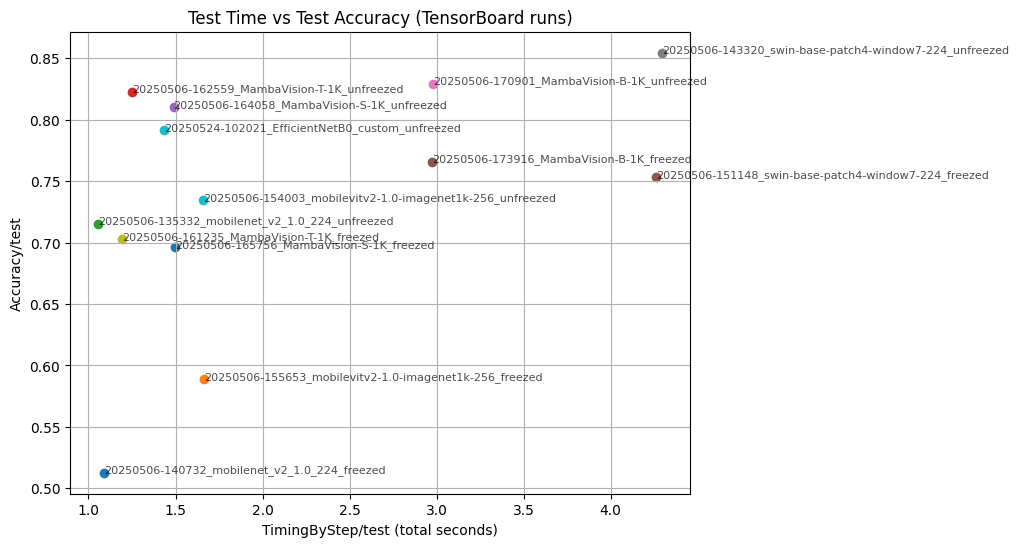

In [13]:
# Get the TensorBoard logs from the runs folder
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import struct

def get_tensorboard_scalars(log_dir):
    """
    Get scalar results from all TensorBoard event files in a directory.
    Returns a dict: {run_name: {tag: [(step, value), ...]}}
    """
    results = {}
    log_dir = str(log_dir)
    for run_dir in os.listdir(log_dir):
        run_path = os.path.join(log_dir, run_dir)
        if not os.path.isdir(run_path):
            continue
        # Find event files in the run directory
        event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]
        if not event_files:
            continue
        # Use the first event file found
        event_file = os.path.join(run_path, event_files[0])
        ea = EventAccumulator(event_file)
        ea.Reload()
        scalars = {}
        for tag in ea.Tags().get("scalars", []):
            events = ea.Scalars(tag)
            scalars[tag] = [(e.step, e.value) for e in events]
        results[run_dir] = scalars
    return results

# Get the results from the tensorboard logs
log_dir = ROOT_FOLDER / "runs"
results = get_tensorboard_scalars(log_dir)

# Scatter plot: TimingByStep/test (x) vs Accuracy/test (y) for each run

x_vals = []
y_vals = []
run_labels = []

for run, tags in results.items():
    timing = tags.get("TimingByStep/test")
    accuracy = tags.get("Accuracy/test")
    if timing and accuracy:
        x = timing[-1][1] if len(timing) > 0 else None
        y = accuracy[-1][1] if len(accuracy) > 0 else None
        if x is not None and y is not None:
            x_vals.append(x)
            y_vals.append(y)
            run_labels.append(run)

# Get the efficientnet results from "tensors" tag
run = '20250524-102021_EfficientNetB0_custom_unfreezed'
log_dir = ROOT_FOLDER / "runs" / run
event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")]
ea = EventAccumulator(os.path.join(log_dir, event_files[0]))
ea.Reload()
baseline = {'run': run}
for tag in ea.Tags().get("tensors", []):
    if tag in ['TimingByStep/test', 'Accuracy/test']:
        events = ea.Tensors(tag)
        values = []
        for e in events:
            tensor_content = e.tensor_proto.tensor_content
            values.append(
                struct.unpack("f", tensor_content)[0] if len(tensor_content) == 4 else tensor_content
            )
        baseline[tag] = values
# Finally, add the baseline values to the x and y values
x_vals.append(baseline['TimingByStep/test'][-1])
y_vals.append(baseline['Accuracy/test'][-1])
run_labels.append(run)

# Get a different color for each run with a colormap with at least 15 distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, len(x_vals)))

plt.figure(figsize=(8, 6))
for i, (x, y, label) in enumerate(zip(x_vals, y_vals, run_labels)):
    plt.scatter(x, y, color=colors[i], label=label)
    plt.annotate(label, (x, y), fontsize=8, alpha=0.7)
plt.xlabel("TimingByStep/test (total seconds)")
plt.ylabel("Accuracy/test")
plt.title("Test Time vs Test Accuracy (TensorBoard runs)")
plt.grid(True)
plt.show()

# INTERPRETABILITE

Concernant l'interprétabilité des modèles, j'ai utilisé la librairie `captum` pour visualiser les cartes de chaleur (heatmaps) des activations des modèles sur un échantillon d'images du dataset, notamment utilisé pour le front. Cela permet de comprendre quelles parties de l'image sont les plus importantes pour la classification par le modèle.

Voici les techniques utilisées pour l'interprétabilité :
- **Globale : Permutation Feature Importance (PFI)** pour évaluer l'importance des caractéristiques globales du modèle. Les canaux de couleurs sont permutés pour mesurer l'impact sur la performance du modèle et comment cela affecte l'accuracy.
- **Locale : Integrated Gradients (IG)** pour visualiser les contributions des pixels individuels à la prédiction du modèle. Cette méthode permet de comprendre quelles parties de l'image ont le plus contribué à la décision du modèle pour une image donnée.
- **Locale : Occlusion Sensitivity** pour évaluer l'importance des régions de l'image en masquant progressivement des parties de l'image et en observant comment cela affecte la prédiction du modèle. Cette méthode permet de visualiser les zones critiques pour la classification.

## GLOBALE

In [15]:
# VARS
MODEL_PATH = ARTIFACTS_FOLDER / "20250506-162559_MambaVision-T-1K_unfreezed.pth"
MODEL_CARD = "nvidia/MambaVision-T-1K"

In [16]:
# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(MODEL_CARD, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(MODEL_CARD),
)
# Load the model weights
model.load_state_dict(
                    torch.load(MODEL_PATH)
                )
# Define the image processor from internal method
transform = model.create_transform(
    training=False
)

# Loading the samples
samples = glob.glob("samples/*.jpg")
n_samples = len(samples)
print(f"Number of samples: {n_samples}")

Number of samples: 14


In [18]:
# Create the test loader with the samples
test_dataset = ImageDataset(
    dataframe=test,
    image_dir=IMAGE_FOLDER,
    processor=None,
    transform=transform,
)
test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False
)

In [20]:
# Permutation Feature Importance on RGB channels
def evaluate_model(model, dataloader):
    model.eval()
    model.to(DEVICE)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def permute_channel(inputs, channel_idx):
    inputs_permuted = inputs.clone()
    # Permute channel_idx channel across all images in the batch
    for i in range(inputs.size(0)):
        flat = inputs_permuted[i, channel_idx].flatten()
        permuted = flat[torch.randperm(flat.numel())]
        inputs_permuted[i, channel_idx] = permuted.view_as(inputs_permuted[i, channel_idx])
    return inputs_permuted

# Evaluate the baseline accuracy
base_acc = evaluate_model(model, test_loader)
print(f"Baseline accuracy: {base_acc:.3f}")

# For each channel (R, G, B), permute the channel and evaluate the model
for ch in range(3):
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs_perm = permute_channel(inputs, ch).to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs_perm)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    perm_acc = correct / total
    print(f"Channel {ch} permuted accuracy: {perm_acc:.3f}, drop: {base_acc - perm_acc:.3f}")

Baseline accuracy: 0.823
Channel 0 permuted accuracy: 0.247, drop: 0.576
Channel 1 permuted accuracy: 0.146, drop: 0.677
Channel 2 permuted accuracy: 0.266, drop: 0.557


## LOCALE

Pour des raisons de compatibilité avec `captum`, la version de numpy a été downgradée à 1.26.4 uniquement pour ce bloc **d'interprétabilité locale**.

Pour reproduire l'expérience, il est nécessaire de passer `uv add captum` dans le terminal.<br>
Pour repasser à la bonne version de numpy par la suite, il faut exécuter `uv remove captum` dans le terminal puis `uv add numpy==2.2.5`.

A noter également que pour la visualisation, les transformations par le prétraitement pour MambaVision introduisent du cropping et celles-ci ont dont été reproduites afin que les gradients et les occlusions soient calculés sur les mêmes zones de l'image que celles utilisées après transformation.

**Occlusion**<br>
L’occlusion est une méthode d’interprétabilité locale qui permet de comprendre quelles zones de l’image influencent la prédiction du modèle.
Son fonctionnement est le suivant :
- On prend une image d’entrée.
- On coupe l’image en petits patches (par ex. 30×30 pixels).
- On masque un patch à la fois par une zone noire.
- On observe comment la prédiction change quand cette zone est masquée.
- Si la prédiction chute fortement, la zone était importante dans le résultat de la prédiction du modèle.

**Integrated Gradient**<br>
C’est une méthode d’attribution qui quantifie l’importance de chaque pixel (ou feature) d’une entrée pour une prédiction donnée. Elle est basée sur les gradients, mais de manière plus stable et interprétable.

Voici comment elle fonctionne :
- On définit une baseline (image de référence, par ex. une image toute noire).
- On interpole linéairement entre la baseline et l’image d’entrée (ex : 50 images entre les deux).
- Pour chaque étape, on calcule le gradient de la prédiction par rapport à l’entrée interpolée.
- On fait la moyenne des gradients le long de ce chemin.
- On multiplie le résultat par la différence entre l’image d’entrée et la baseline.

In [ ]:
from captum.attr import IntegratedGradients, Occlusion
from torchvision.transforms.functional import to_pil_image
import numpy as np
import math

In [13]:
# VARS
MODEL_PATH = ARTIFACTS_FOLDER / "20250506-162559_MambaVision-T-1K_unfreezed.pth"
MODEL_CARD = "nvidia/MambaVision-T-1K"

In [14]:
# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(MODEL_CARD, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(MODEL_CARD),
)
# Load the model weights
model.load_state_dict(
                    torch.load(MODEL_PATH)
                )
# Define the image processor from internal method
transform = model.create_transform(
    training=False
)

# Loading the samples
samples = glob.glob("samples/*.jpg")
n_samples = len(samples)
print(f"Number of samples: {n_samples}")

Number of samples: 14


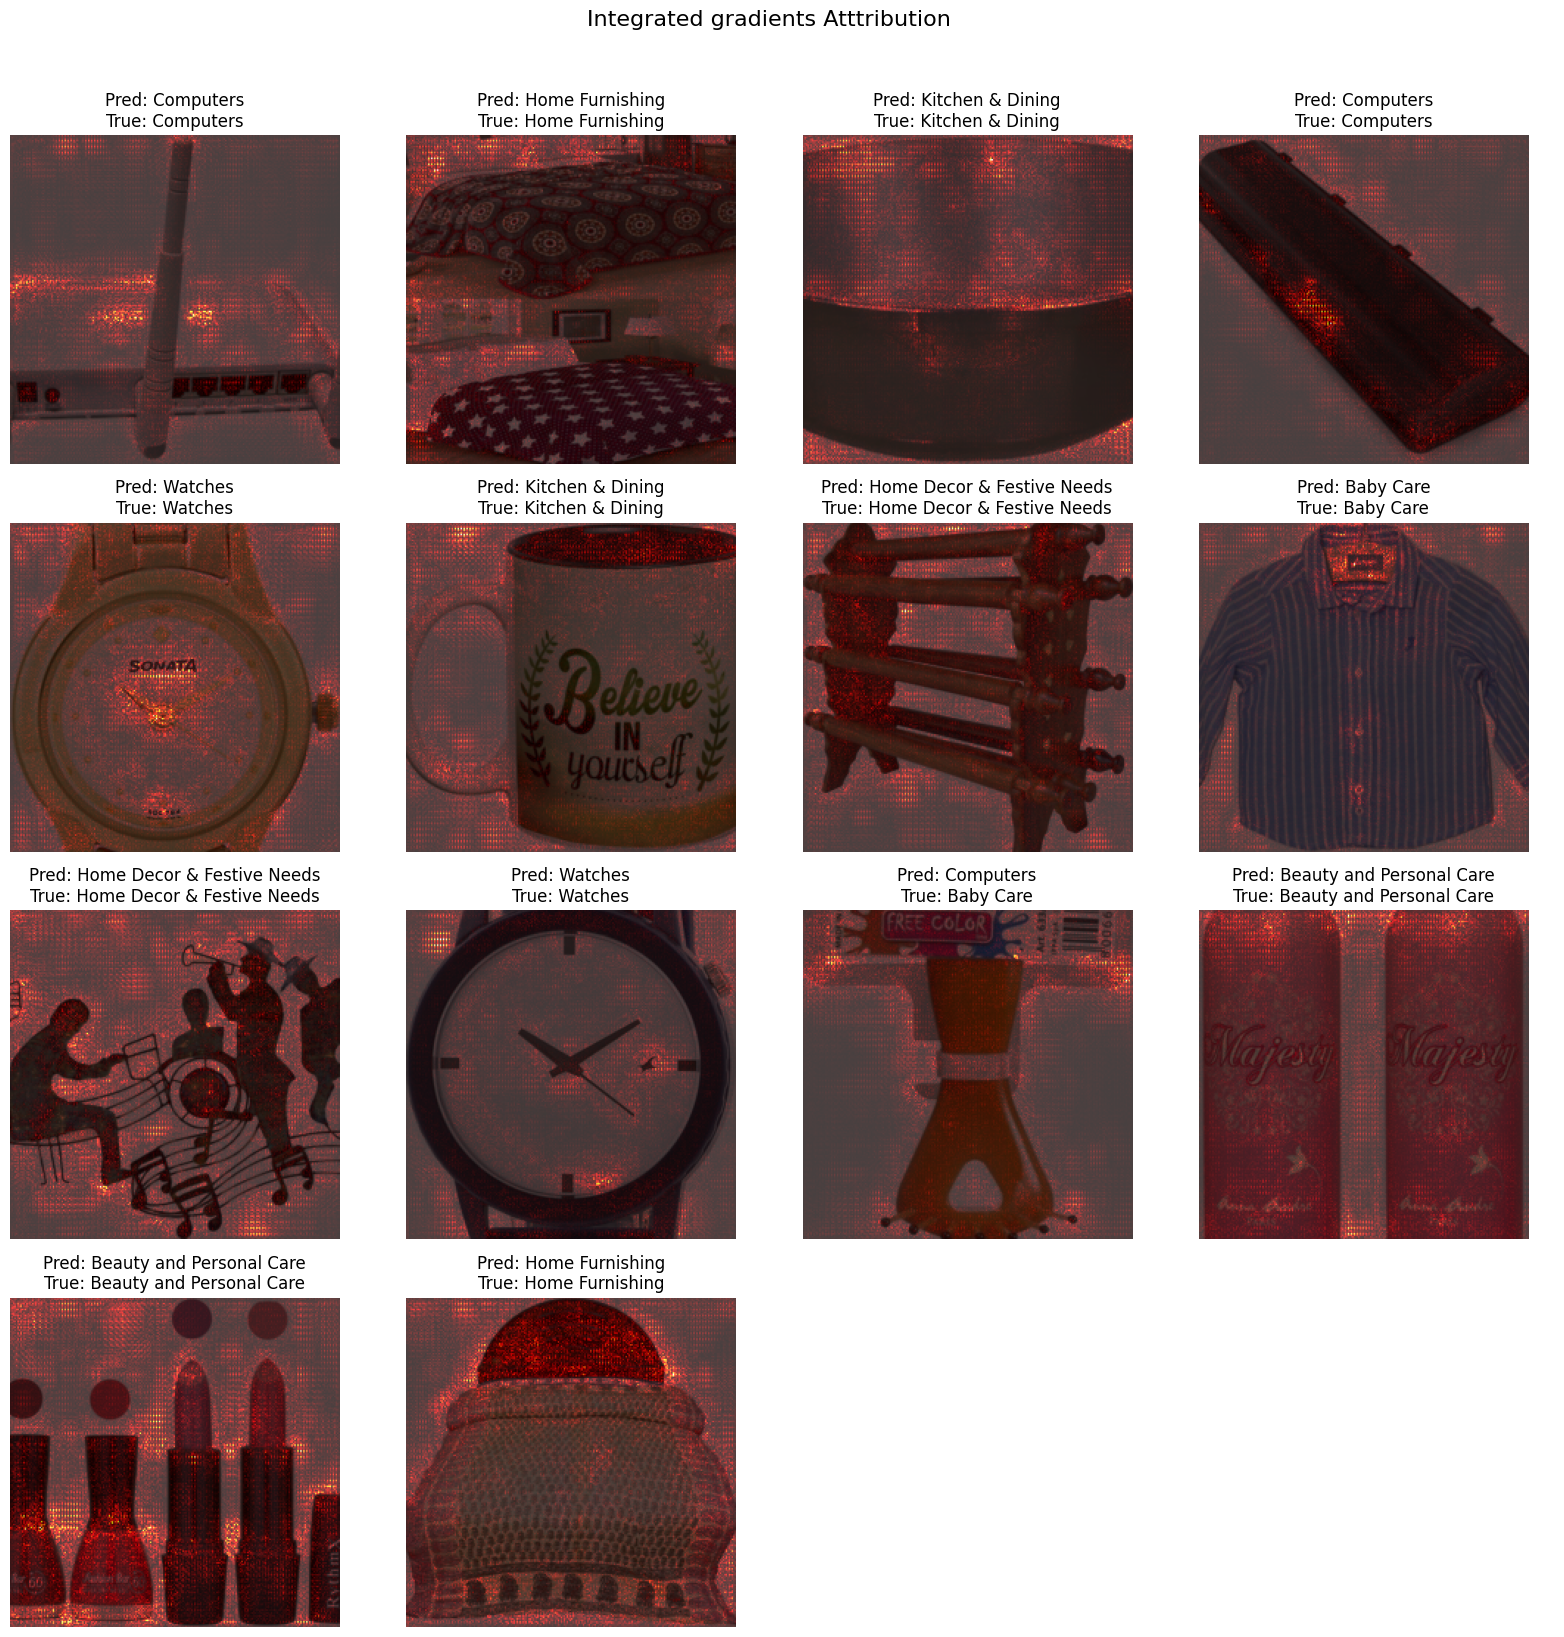

In [ ]:
# Figure setup
n_cols = 4
n_rows = math.ceil(n_samples / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
fig.suptitle("Integrated gradients Atttribution", fontsize=16, y=1.02)
model.eval()
model.to(DEVICE)

# Iterate over the samples and compute the integrated gradients
for idx, sample in enumerate(samples):
    img = Image.open(sample).convert("RGB")
    img_name = sample.split("/")[-1]
    label_idx = df.loc[df["image"] == img_name, "class"]
    label_name = le.inverse_transform([label_idx.values[0]])[0]  # Get the true label
    # show the image after transformation
    img_transformed = transform(img)
    img = img_transformed * torch.tensor(model.config.std).view(3, 1, 1) + torch.tensor(model.config.mean).view(3, 1, 1)
    pil_image = to_pil_image(img)
    input_tensor = img_transformed.unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad = True
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(
        input_tensor,
        target=pred_class,
        return_convergence_delta=True
    )
    attributions = attributions.squeeze().detach().cpu().numpy()
    attributions = np.abs(attributions).mean(axis=0)
    ax = axes.flat[idx]
    ax.imshow(pil_image)
    ax.imshow(attributions, cmap='hot', alpha=0.75)
    ax.axis("off")
    ax.set_title(f"Pred: {le.inverse_transform([pred_class])[0]}\nTrue: {label_name}")
# Hide any unused subplots
for j in range(idx + 1, n_rows * n_cols):
    axes.flat[j].axis("off")
plt.tight_layout()
plt.show()

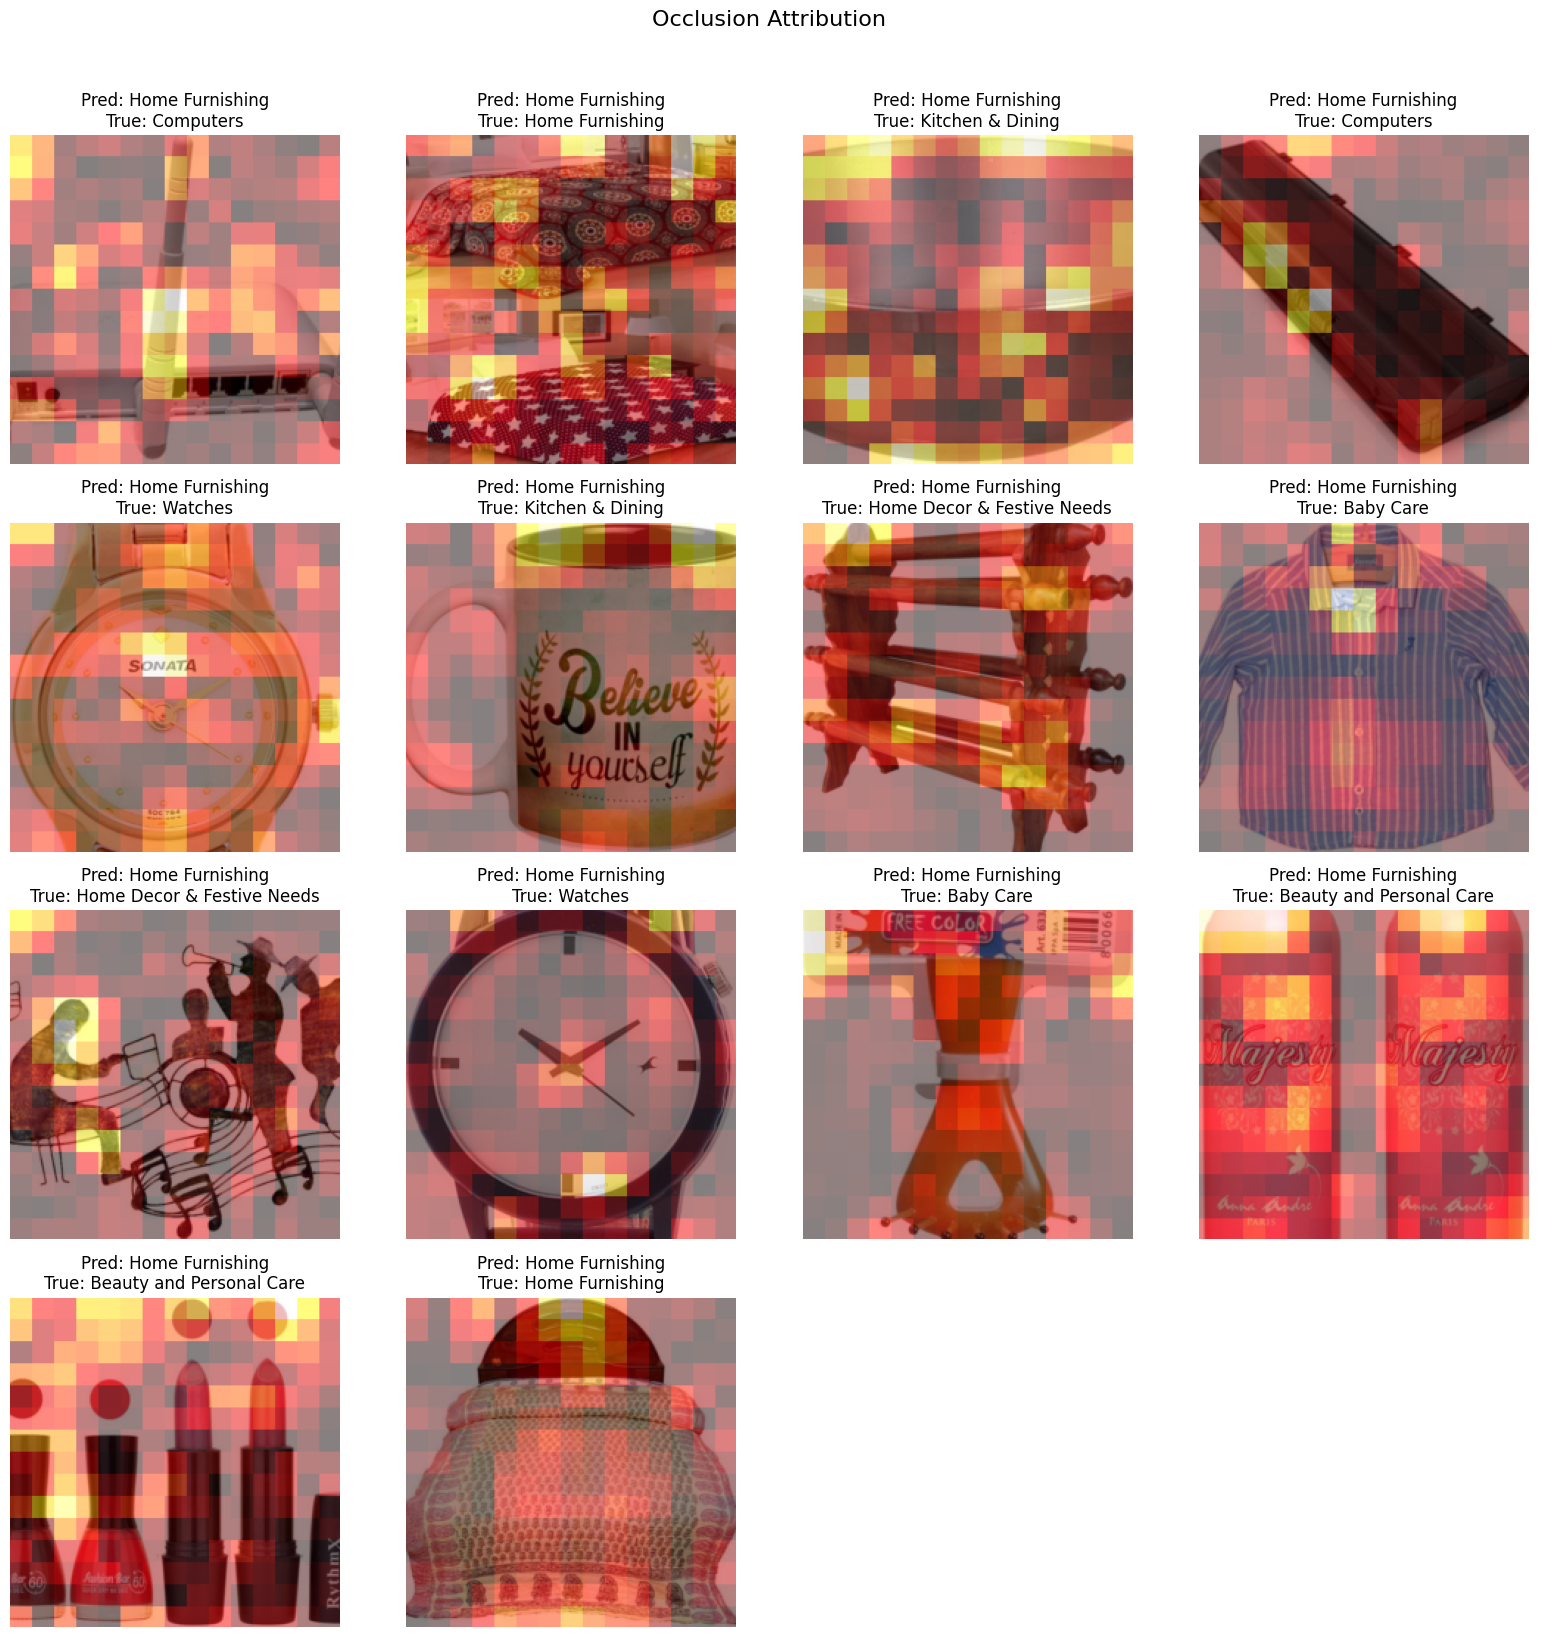

In [ ]:
# Figure setup
n_cols = 4
n_rows = math.ceil(n_samples / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
fig.suptitle("Occlusion Attribution", fontsize=16, y=1.02)
model.eval()
model.to(DEVICE)

# Iterate over the samples and compute the occlusion attribution
for idx, sample in enumerate(samples):
    img = Image.open(sample).convert("RGB")
    img_name = sample.split("/")[-1]
    label_idx = df.loc[df["image"] == img_name, "class"]
    label_name = le.inverse_transform([label_idx.values[0]])[0]  # Get the true label
    # show the image after transformation
    img_transformed = transform(img)
    img = img_transformed * torch.tensor(model.config.std).view(3, 1, 1) + torch.tensor(model.config.mean).view(3, 1, 1)
    pil_image = to_pil_image(img)
    input_tensor = img_transformed.unsqueeze(0).to(DEVICE)
    target_class = model(input_tensor).argmax(dim=1).item()
    occlusion = Occlusion(model)
    attributions = occlusion.attribute(
    input_tensor,
    strides = (3, 15, 15),
    sliding_window_shapes = (3, 30, 30),
    target = target_class
    )

    attr = attributions.squeeze().cpu().detach().numpy()
    attr = np.abs(attr).mean(axis=0)
    ax = axes.flat[idx]

    ax.imshow(pil_image)
    ax.imshow(attr, cmap='hot', alpha=0.5)
    ax.axis("off")
    ax.set_title(f"Pred: {le.inverse_transform([pred_class])[0]}\nTrue: {label_name}")
# Hide any unused subplots
for j in range(idx + 1, n_rows * n_cols):
    axes.flat[j].axis("off")
plt.tight_layout()
plt.show()